In [1]:
import sys
sys.path.insert(0, "../src/")

In [2]:
from pandas import DataFrame

In [3]:
from reviewer.framework import Runtime, Workflow, Analysis, Dataset, Figure
from reviewer.framework.step import *

# Configure steps

In [4]:
pconfig = PreprocessorConfig(input_field            = "input_text",
                             output_field           = "clean_text",
                             do_stem                = True,
                             do_remove_stopwords    = True,
                             do_remove_punctuation  = True,
                             do_remove_nonascii     = True)

preproc = Preprocessor(config = pconfig)

In [5]:
emconfig = TfIdfEmbedderConfig(input_field   = "clean_text",
                               output_prefix = "emb_",
                               ngram_range   = (1, 1),
                            
                               max_features       = 1024,
                               use_svd            = True,
                               max_svd_components = 4)

embedder = TfIdfEmbedder(config = emconfig)

In [6]:
nconfig = NgramAnalyserConfig(input_field = "clean_text",
                              output_name = "ngrams",
                              ngram_range = (1, 2),
                              max_ngrams = 10)

ngrams = NgramAnalyser(config = nconfig)

In [7]:
lrconfig = LogisticRegressionConfig(input_field                 = "y_sentiment",
                                    output_prob_field           = "y_prob_lr",
                                    output_class_field          = "y_pred_lr",
                                    embedding_prefix            = "emb_",
                                    review_field                = "clean_text",
                                    additional_regressor_fields = [],
                                    classification_threshold    = 0.5)

lr = LogisticRegression(config = lrconfig)

In [8]:
svmconfig = SVMConfig(input_field                 = "y_sentiment",
                      output_prob_field           = "y_prob_svm",
                      output_class_field          = "y_pred_svm",
                      embedding_prefix            = "emb_",
                      review_field                = "clean_text",
                      additional_regressor_fields = [],
                      classification_threshold    = 0.5)

svm = SVM(config = svmconfig)

In [9]:
beconfig = BinaryEvaluationMetricConfig(input_field             = "y_sentiment",
                                        prediction_field_prefix = "y_prob",
                                        output_name             = "binary_metrics")

be = BinaryEvaluationMetric(config = beconfig)

In [10]:
cmconfig = ConfusionMatrixConfig(input_field             = "y_sentiment",
                                 prediction_field_prefix = "y_prob",
                                 output_name_prefix      = "confusion_matrix_")

cm = ConfusionMatrix(config = cmconfig)

In [11]:
vwcconfig = WordCloudConfig(input_field = "clean_text",
                            output_name = "word_cloud",
                            title       = "Word Cloud")

vwc = WordCloud(config = vwcconfig)

# Create workflow

In [12]:
workflow = (Workflow()

             # Datenaufbereitung
             .add(preproc)
             .add(embedder)

             # Deskriptive und temporale Analysen
             .add(ngrams)
            
            
             # Binäre Klassifizierer
             .add(lr)
             .add(svm)
            
            # Evaluierungsmetriken
             .add(be)            
             .add(cm)            
           
            # Visualisierungen
             .add(vwc))

# Create analysis

In [13]:
analysis = Analysis().add(workflow)

# Create / load dataset

In [14]:
df = DataFrame({
    "text": [
        "Absolutely loved it! Will buy again.",
        "Terrible quality. Broke after a day.",
        "Good value for the price.",
        "Not what I expected, but okay.",
        "Exceeded my expectations!",
        "Would not recommend to anyone.",
        "Decent product, fast shipping.",
        "Packaging was poor, item damaged.",
        "Fantastic service and quality.",
        "Meh, it’s fine but not great."
    ],
    "rating": [5, 1, 4, 3, 5, 1, 4, 2, 5, 3],
    "year": [2023, 2022, 2023, 2021, 2024, 2022, 2023, 2021, 2024, 2022],
    "product_id": [101, 102, 101, 103, 104, 105, 103, 102, 104, 101],
    "user_id": [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010],
    "y_sentiment": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],  
    "y_useful": [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]  
})

ds = Dataset(df)

ds

                                   text  rating  year  product_id  user_id  \
0  Absolutely loved it! Will buy again.       5  2023         101     1001   
1  Terrible quality. Broke after a day.       1  2022         102     1002   
2             Good value for the price.       4  2023         101     1003   
3        Not what I expected, but okay.       3  2021         103     1004   
4             Exceeded my expectations!       5  2024         104     1005   

   y_sentiment  y_useful  
0            1         1  
1            0         0  
2            1         1  
3            0         0  
4            1         1  

# Configure runtime

In [15]:
runtime = Runtime(dataset_constructor = Dataset.new,
                  figure_constructor = Figure.new)

(Optional) Configure logger

In [16]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(name)-12s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


In [17]:
from reviewer.framework.interface import ILogger

In [18]:
class Logger(ILogger):
    def __init__(self):
        self._logger = logging.getLogger("analysis")

    def log(self, msg):
        self._logger.info(msg)

logger = Logger()

# Run analysis

In [19]:
analysis.get_fields().required

{'input_text': FieldSchema(dtype=<class 'str'>, prefix=False, description='To be preprocessed text'),
 'y_sentiment': FieldSchema(dtype=<class 'int'>, prefix=False, description='Target variable')}

In [20]:
analysis.get_fields().created

{'clean_text': FieldSchema(dtype=<class 'str'>, prefix=False, description='Preprocessed text'),
 'emb_': FieldSchema(dtype=<class 'str'>, prefix=True, description='Embedding fields'),
 'y_prob_lr': FieldSchema(dtype=<class 'float'>, prefix=False, description='Predicted probability score'),
 'y_pred_lr': FieldSchema(dtype=<class 'int'>, prefix=False, description='Predicted binary class'),
 'y_prob_svm': FieldSchema(dtype=<class 'float'>, prefix=False, description='Predicted probability score'),
 'y_pred_svm': FieldSchema(dtype=<class 'int'>, prefix=False, description='Predicted binary class')}

In [21]:
analysis.get_results()

{'1747035042_139810156712672': {'ngrams': <ResultType.DATASET: 'dataset'>,
  'binary_metrics': <ResultType.DATASET: 'dataset'>,
  'confusion_matrix_': <ResultType.DATASET: 'dataset'>,
  'word_cloud': <ResultType.FIGURE: 'figure'>}}

In [22]:
ds_post, results = analysis.run(runtime, ds, mapping={"input_text":  "text",  
                                                      "y_sentiment": "y_sentiment"},
                               logger=logger)

2025-05-12 09:30:42 [INFO] analysis     Starting workflow 'Default workflow (1747035042_139810156712672)'
2025-05-12 09:30:42 [INFO] analysis     Running step 'Preprocessor'
2025-05-12 09:30:42 [INFO] analysis     Running step 'TF-IDF-Embedder'
2025-05-12 09:30:42 [INFO] analysis     Running step 'NgramAnalyser'
2025-05-12 09:30:42 [INFO] analysis     Running step 'Logistic regression'
2025-05-12 09:30:42 [INFO] analysis     Running step 'SVM'
2025-05-12 09:30:42 [INFO] analysis     Running step 'Evaluation metric'
2025-05-12 09:30:42 [INFO] analysis     Running step 'Confusion matrix'
2025-05-12 09:30:42 [INFO] analysis     Running step 'Word cloud'


In [23]:
ds_post

                                   text  rating  year  product_id  user_id  \
0  Absolutely loved it! Will buy again.       5  2023         101     1001   
1  Terrible quality. Broke after a day.       1  2022         102     1002   
2             Good value for the price.       4  2023         101     1003   
3        Not what I expected, but okay.       3  2021         103     1004   
4             Exceeded my expectations!       5  2024         104     1005   

   y_sentiment  y_useful                            input_text  \
0            1         1  Absolutely loved it! Will buy again.   
1            0         0  Terrible quality. Broke after a day.   
2            1         1             Good value for the price.   
3            0         0        Not what I expected, but okay.   
4            1         1             Exceeded my expectations!   

                  clean_text         emb_0         emb_1         emb_2  \
0           absolut love buy  1.294070e-16  1.373571e-17  9.

In [24]:
results_flat = [xi for w in results.values() for x in w.values() for xi in x]

In [25]:
results_flat[0]

          ngram  frequency
0       qualiti          2
1        expect          2
2       absolut          1
3          love          1
4  absolut love          1

In [26]:
results_flat[1]

     variable  accuracy  precision  recall        f1
0   y_prob_lr       0.8   0.714286     1.0  0.833333
1  y_prob_svm       0.3   0.375000     0.6  0.461538

In [27]:
results_flat[2]

      real  Predict 0  Predict 1
0  Value 0          3          2
1  Value 1          0          5

In [28]:
results_flat[3]

      real  Predict 0  Predict 1
0  Value 0          0          5
1  Value 1          2          3

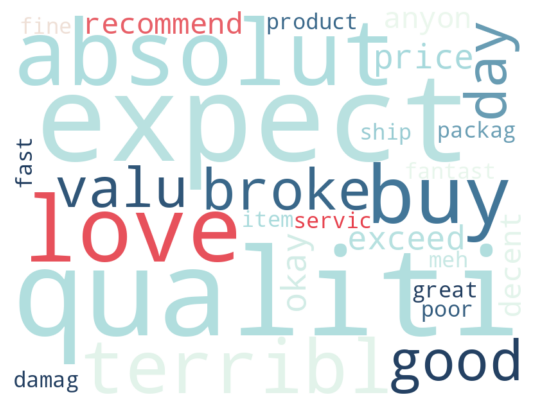

In [29]:
results_flat[4].value.raw